In [2]:
# Restaurant Simulation Testing & Configuration Notebook
# This notebook demonstrates how to use the updated restaurant simulation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List
import json

# Import simulation components
from parameters import SingleDishParameters
from simulation import SingleDishRestaurantSim
from results import calculate_results, format_results, print_results
from dish_loading import load_recipes_from_json  # Add this line
import dish_recipes

In [3]:
# ============================================================================
# SIMULATION FLOW WALKTHROUGH
# ============================================================================

"""
The restaurant simulation follows this flow:

1. GUEST ARRIVAL
   - Guests arrive according to NHPP (Non-Homogeneous Poisson Process)
   - Party size generated (1-10 people, weighted distribution)
   - Party added to GUEST QUEUE

2. TABLE MATCHING
   - Table matching dispatcher checks for available tables
   - Matches party size to appropriate table (minimize waste)
   - Uses round-robin zone balancing
   - When match found → party moved to HOST QUEUE

3. HOST SEATING
   - Host picks party from host queue (FIFO)
   - Host walks party to table (time delay)
   - Party seated → table assigned

4. ORDERING
   - Party decides on order (decision time, no server needed)
   - Server takes order (ORDERING task in server zone queue)
   - Order created with dishes

5. KITCHEN (Component-Based Cooking)
   - Each dish has recipe → multiple components
   - Components routed to stations in PARALLEL:
     * wood_grill
     * salad_station
     * sautee_station
     * tortilla_station
     * guac_station
   - When ALL components complete → dish goes to EXPO

6. EXPO (Quality Check)
   - Expo checks each dish (time delay)
   - Dishes batched by order
   - When ALL dishes in order pass expo → DELIVERY task created

7. DELIVERY
   - Delivery task added to BOTH:
     * Food Runner Queue (global)
     * Server Zone Queue (zone-specific)
   - Food runner OR server can claim task
   - When claimed, removed from other queue

8. DINING
   - Party dines (lognormal time, scales with party size)
   - Starts when first dish delivered

9. CHECKOUT
   - After dining, CHECKOUT task created
   - Server processes payment (server-only task)

10. CLEANUP
    - CLEANING task created
    - Added to BOTH:
      * Busser Queue (global)
      * Server Zone Queue (zone-specific)
    - Busser OR server can claim task
    - Tables released back to pool
"""

print("Simulation flow documented above!")

Simulation flow documented above!


In [4]:
# ============================================================================
# BASIC USAGE: Run Simulation with Comal Recipes
# ============================================================================

def run_comal_simulation(duration_minutes=240, verbose=True, use_comal_recipes=True):
    """Run simulation with Comal restaurant recipes from JSON file.
    
    Args:
        duration_minutes: Simulation duration in minutes
        verbose: If True, print formatted results
        use_comal_recipes: If True, load recipes from comal_recipes.json
                          If False, use default parameters
    """
    
    # Load recipes and menu catalog from JSON file, or use defaults
    if use_comal_recipes:
        print("Loading Comal recipes from comal_recipes.json...")
        params = load_recipes_from_json('comal_recipes.json')
        print(f"✓ Loaded {len(params.dish_recipes)} dishes with prices")
        print(f"✓ Menu distribution: {len(params.menu_distribution)} items")
        if params.menu_catalog:
            print(f"✓ Menu catalog: {len(params.menu_catalog)} items with prices")
    else:
        print("Using default parameters...")
        params = SingleDishParameters()
    
    params.simulation_duration = duration_minutes
    params.enable_logging = True  # Set to True to see snapshots
    
    # Create and run simulation
    sim = SingleDishRestaurantSim(params)
    results = sim.run()
    
    # Add config for formatting
    results['num_tables'] = params.num_tables
    results['num_servers'] = params.num_servers
    results['num_cooks'] = params.num_cooks
    results['simulation_duration'] = params.simulation_duration
    
    if verbose:
        print_results(results)
    
    return sim, results

# Run a simulation with Comal recipes
print("=" * 70)
print("COMAL RESTAURANT SIMULATION (4 hours)")
print("=" * 70)
sim, results = run_comal_simulation(duration_minutes=240, verbose=True, use_comal_recipes=True)

COMAL RESTAURANT SIMULATION (4 hours)
Loading Comal recipes from comal_recipes.json...
✓ Loaded 92 dishes with prices
✓ Menu distribution: 92 items
✓ Menu catalog: 92 items with prices
RESTAURANT SIMULATION RESULTS

🎯 PRIMARY KPI: NET REVPASH
----------------------------------------------------------------------
  Net RevPASH: $0.63 per seat-hour
  (Revenue - Labor Cost) / Seat Hours
  Gross RevPASH: $3.16 per seat-hour

📊 CONFIGURATION
----------------------------------------------------------------------
  Tables: 41 (Total Seats: 136)
  Servers: 4, Cooks: 4
  Simulation Duration: 4.0 hours

👥 THROUGHPUT & SERVICE RATE
----------------------------------------------------------------------
  Parties Arrived: 88
  Parties Served: 34 (38.6%)
  Parties with Table: 75
  Parties Abandoned: 41
  Parties Waiting for Table: 13

👥 GUEST COUNT & PARTY SIZE
----------------------------------------------------------------------
  Total Guests Arrived: 248
  Total Guests Served: 79
  Avg Party Siz

In [ ]:
# ============================================================================
# RUN SIMULATION WITH LOGGING ENABLED
# ============================================================================

def run_comal_simulation_with_logs(duration_minutes=60, verbose=True, use_comal_recipes=True):
    """Run simulation with logging enabled and return sim object."""
    
    # Load recipes and menu catalog from JSON file, or use defaults
    if use_comal_recipes:
        print("Loading Comal recipes from comal_recipes.json...")
        params = load_recipes_from_json('comal_recipes.json')
        print(f"✓ Loaded {len(params.dish_recipes)} dishes with prices")
    else:
        print("Using default parameters...")
        params = SingleDishParameters()
    
    params.simulation_duration = duration_minutes
    params.enable_logging = True  # Enable logging
    params.enable_event_logging = True  # Enable event log
    params.min_snapshot_interval = 0.5  # 30 seconds between snapshots
    
    # Create and run simulation
    sim = SingleDishRestaurantSim(params)
    results = sim.run()
    
    # Add config for formatting
    results['num_tables'] = params.num_tables
    results['num_servers'] = params.num_servers
    results['num_cooks'] = params.num_cooks
    results['simulation_duration'] = params.simulation_duration
    
    if verbose:
        print_results(results)
    
    return sim, results

# Run simulation
print("=" * 70)
print("RUNNING SIMULATION WITH LOGGING")
print("=" * 70)
sim, results = run_comal_simulation_with_logs(duration_minutes=60, verbose=True, use_comal_recipes=True)

RUNNING SIMULATION WITH LOGGING
Loading Comal recipes from comal_recipes.json...
✓ Loaded 35 dishes with prices
RESTAURANT SIMULATION RESULTS

🎯 PRIMARY KPI: NET REVPASH
----------------------------------------------------------------------
  Net RevPASH: $3.73 per seat-hour
  (Revenue - Labor Cost) / Seat Hours
  Gross RevPASH: $8.73 per seat-hour

📊 CONFIGURATION
----------------------------------------------------------------------
  Tables: 20 (Total Seats: 60)
  Servers: 4, Cooks: 4
  Simulation Duration: 4.0 hours

👥 THROUGHPUT & SERVICE RATE
----------------------------------------------------------------------
  Parties Arrived: 112
  Parties Served: 33 (29.5%)
  Parties with Table: 53
  Parties Abandoned: 20
  Parties Waiting for Table: 59

👥 GUEST COUNT & PARTY SIZE
----------------------------------------------------------------------
  Total Guests Arrived: 331
  Total Guests Served: 74
  Avg Party Size (All): 2.96 guests
  Avg Party Size (Served): 2.24 guests
  Party Size 

In [7]:
# ============================================================================
# VIEW LOG SUMMARY
# ============================================================================

from collections import Counter

print("=" * 70)
print("LOG SUMMARY")
print("=" * 70)

print(f"\n📊 SNAPSHOTS")
print(f"  Total snapshots: {len(sim.snapshot_history)}")
if sim.snapshot_history:
    times = [s['time'] for s in sim.snapshot_history]
    print(f"  Time range: {min(times):.1f} - {max(times):.1f} minutes")
    print(f"  Average interval: {(max(times) - min(times)) / len(sim.snapshot_history):.2f} minutes")
    print(f"  Last snapshot time: {max(times):.1f} minutes")

print(f"\n📝 EVENTS")
print(f"  Total events: {len(sim.event_log)}")
if sim.event_log:
    event_counts = Counter(e['event_type'] for e in sim.event_log)
    print(f"  Event types:")
    for event_type, count in sorted(event_counts.items()):
        print(f"    {event_type}: {count}")
    
    event_times = [e['timestamp'] for e in sim.event_log]
    print(f"  Time range: {min(event_times):.1f} - {max(event_times):.1f} minutes")

print(f"\n💾 DATA SIZES")
if sim.snapshot_history:
    last_snap = sim.snapshot_history[-1]
    print(f"  Parties tracked: {len(last_snap['parties'])}")
    print(f"  Dishes tracked: {len(last_snap['dishes'])}")
    print(f"  Orders tracked: {len(last_snap['orders'])}")
    print(f"  Tables tracked: {len(last_snap['tables'])}")
    print(f"  Stations tracked: {len(last_snap['stations'])}")

LOG SUMMARY

📊 SNAPSHOTS
  Total snapshots: 277
  Time range: 13.8 - 239.4 minutes
  Average interval: 0.81 minutes
  Last snapshot time: 239.4 minutes

📝 EVENTS
  Total events: 1519
  Event types:
    dish_completed: 161
    dish_delivered: 127
    dish_expo_complete: 161
    dish_expo_start: 161
    dish_started: 177
    order_created: 53
    party_arrived: 112
    party_departed: 33
    party_seated: 53
    task_completed: 159
    task_created: 161
    task_started: 161
  Time range: 13.8 - 239.6 minutes

💾 DATA SIZES
  Parties tracked: 112
  Dishes tracked: 187
  Orders tracked: 53
  Tables tracked: 20
  Stations tracked: 5


In [8]:
# ============================================================================
# VIEW SAMPLE SNAPSHOTS
# ============================================================================

def view_snapshot(snapshot, show_details=False):
    """Display a snapshot in readable format."""
    print(f"\n{'='*70}")
    print(f"SNAPSHOT at t={snapshot['time']:.2f} minutes")
    print(f"{'='*70}")
    
    print(f"\n📊 AGGREGATE METRICS")
    print(f"  Parties in system: {snapshot['parties_in_system']}")
    print(f"  Parties served: {snapshot['parties_served']}")
    print(f"  Total revenue: ${snapshot['total_revenue']:.2f}")
    print(f"  Guest queue: {snapshot['guest_queue_length']}")
    print(f"  Host queue: {snapshot['host_queue_length']}")
    print(f"  Expo queue: {snapshot['expo_queue_length']}")
    print(f"  Food runner queue: {snapshot['food_runner_queue']}")
    print(f"  Busser queue: {snapshot['busser_queue']}")
    
    print(f"\n🍳 STATIONS")
    for station_name in ['wood_grill', 'salad_station', 'sautee_station', 'tortilla_station', 'guac_station']:
        queue_key = f"{station_name}_queue"
        busy_key = f"{station_name}_busy"
        if queue_key in snapshot:
            print(f"  {station_name}: queue={snapshot[queue_key]}, busy={snapshot[busy_key]}")
    
    if show_details:
        print(f"\n👥 PARTIES (showing first 5)")
        for party in snapshot['parties'][:5]:
            print(f"  Party {party['id']}: {party['status']} | "
                  f"Size: {party['party_size']} | "
                  f"Tables: {party['tables_assigned']} | "
                  f"Check: ${party['check_total']:.2f}")
        
        print(f"\n🍽️  DISHES (showing first 5)")
        for dish in snapshot['dishes'][:5]:
            print(f"  Dish {dish['id']}: {dish['dish_type']} | "
                  f"Status: {dish['status']} | "
                  f"Order: {dish['order_id']} | "
                  f"Price: ${dish['price']:.2f}")
        
        print(f"\n📋 ORDERS (showing first 5)")
        for order in snapshot['orders'][:5]:
            print(f"  Order {order['order_id']}: Party {order['party_id']} | "
                  f"{order['total_dishes']} dishes | "
                  f"Status: {order['status']}")
        
        print(f"\n🪑 TABLES (occupied)")
        occupied = [t for t in snapshot['tables'] if not t['is_available']]
        for table in occupied[:5]:
            print(f"  Table {table['id']}: Size {table['size']} | "
                  f"Zone {table['zone_id']} | "
                  f"Party {table['party_id']}")

# View first snapshot
if sim.snapshot_history:
    print("\n" + "="*70)
    print("FIRST SNAPSHOT")
    print("="*70)
    view_snapshot(sim.snapshot_history[0], show_details=True)

# View snapshot at 30 minutes (if simulation ran that long)
if sim.snapshot_history:
    times = [s['time'] for s in sim.snapshot_history]
    if max(times) >= 30:
        snap_30 = min(sim.snapshot_history, key=lambda s: abs(s['time'] - 30))
        print("\n" + "="*70)
        print("SNAPSHOT AT 30 MINUTES")
        print("="*70)
        view_snapshot(snap_30, show_details=True)

# View last snapshot
if sim.snapshot_history:
    print("\n" + "="*70)
    print("LAST SNAPSHOT")
    print("="*70)
    view_snapshot(sim.snapshot_history[-1], show_details=True)


FIRST SNAPSHOT

SNAPSHOT at t=13.82 minutes

📊 AGGREGATE METRICS
  Parties in system: 1
  Parties served: 0
  Total revenue: $0.00
  Guest queue: 1
  Host queue: 0
  Expo queue: 0
  Food runner queue: 0
  Busser queue: 0

🍳 STATIONS
  wood_grill: queue=0, busy=0
  salad_station: queue=0, busy=0
  sautee_station: queue=0, busy=0
  tortilla_station: queue=0, busy=0
  guac_station: queue=0, busy=0

👥 PARTIES (showing first 5)
  Party 1: waiting_for_table | Size: 1 | Tables: [] | Check: $0.00

🍽️  DISHES (showing first 5)

📋 ORDERS (showing first 5)

🪑 TABLES (occupied)

SNAPSHOT AT 30 MINUTES

SNAPSHOT at t=30.03 minutes

📊 AGGREGATE METRICS
  Parties in system: 6
  Parties served: 0
  Total revenue: $0.00
  Guest queue: 0
  Host queue: 0
  Expo queue: 0
  Food runner queue: 0
  Busser queue: 0

🍳 STATIONS
  wood_grill: queue=0, busy=2
  salad_station: queue=0, busy=2
  sautee_station: queue=5, busy=2
  tortilla_station: queue=0, busy=3
  guac_station: queue=1, busy=2

👥 PARTIES (showing

In [9]:
# ============================================================================
# VIEW SAMPLE EVENTS
# ============================================================================

def view_events(event_list, limit=20):
    """Display events in readable format."""
    print(f"\n{'='*70}")
    print(f"EVENT LOG (showing {min(limit, len(event_list))} events)")
    print(f"{'='*70}\n")
    
    for i, event in enumerate(event_list[:limit]):
        timestamp = event['timestamp']
        event_type = event['event_type']
        entity_id = event['entity_id']
        
        details_str = ""
        if 'details' in event:
            details = event['details']
            if 'party_id' in details:
                details_str = f" | Party {details['party_id']}"
            elif 'order_id' in details:
                details_str = f" | Order {details['order_id']}"
            elif 'dish_type' in details:
                details_str = f" | {details['dish_type']}"
        
        state_str = ""
        if 'from_state' in event and 'to_state' in event:
            state_str = f" | {event['from_state']} → {event['to_state']}"
        
        print(f"  {timestamp:6.2f} min | {event_type:20s} | Entity {entity_id:3d}{details_str}{state_str}")

# View first 20 events
if sim.event_log:
    view_events(sim.event_log, limit=20)

# View events for a specific party (Party 1)
if sim.event_log:
    party_1_events = [e for e in sim.event_log 
                      if e.get('details', {}).get('party_id') == 1 or 
                         (e['event_type'] in ['party_arrived', 'party_seated', 'party_departed'] and e['entity_id'] == 1)]
    
    if party_1_events:
        print("\n" + "="*70)
        print("EVENTS FOR PARTY 1")
        print("="*70)
        view_events(party_1_events, limit=50)

# View events for a specific dish (Dish 1)
if sim.event_log:
    dish_1_events = [e for e in sim.event_log if e['entity_id'] == 1 and 'dish' in e['event_type']]
    
    if dish_1_events:
        print("\n" + "="*70)
        print("EVENTS FOR DISH 1")
        print("="*70)
        view_events(dish_1_events, limit=50)


EVENT LOG (showing 20 events)

   13.82 min | party_arrived        | Entity   1
   13.96 min | party_arrived        | Entity   2
   14.37 min | party_seated         | Entity   1 | being_seated → deciding
   14.52 min | party_seated         | Entity   2 | being_seated → deciding
   16.85 min | task_created         | Entity   1 | Party 1
   16.85 min | task_started         | Entity   1 | Party 1 | pending → in_progress
   17.77 min | task_created         | Entity   2 | Party 2
   17.77 min | task_started         | Entity   2 | Party 2 | pending → in_progress
   18.39 min | task_completed       | Entity   1 | Party 1 | in_progress → completed
   18.45 min | order_created        | Entity   1 | Party 1
   18.45 min | dish_started         | Entity   1 | Order 1 | queued → cooking
   18.45 min | dish_started         | Entity   2 | Order 1 | queued → cooking
   19.47 min | task_completed       | Entity   2 | Party 2 | in_progress → completed
   19.57 min | order_created        | Entity   2 | 

In [10]:
# ============================================================================
# QUERY LOGS - HELPER FUNCTIONS
# ============================================================================

def get_snapshot_at_time(sim, target_time):
    """Get the snapshot closest to target_time."""
    if not sim.snapshot_history:
        return None
    return min(sim.snapshot_history, key=lambda s: abs(s['time'] - target_time))

def get_party_timeline(sim, party_id):
    """Get all events for a specific party."""
    return [e for e in sim.event_log 
            if e.get('details', {}).get('party_id') == party_id or 
               (e['event_type'] in ['party_arrived', 'party_seated', 'party_departed'] and e['entity_id'] == party_id)]

def get_dish_timeline(sim, dish_id):
    """Get all events for a specific dish."""
    return [e for e in sim.event_log if e['entity_id'] == dish_id and 'dish' in e['event_type']]

def get_parties_at_table(sim, table_id, snapshot_time=None):
    """Get parties that were at a given table at a specific time."""
    if snapshot_time is None:
        snap = sim.snapshot_history[-1] if sim.snapshot_history else None
    else:
        snap = get_snapshot_at_time(sim, snapshot_time)
    
    if not snap:
        return []
    
    return [p for p in snap['parties'] if table_id in p['tables_assigned']]

def get_dish_location(sim, dish_id, snapshot_time=None):
    """Get the location/status of a dish at a specific time."""
    if snapshot_time is None:
        snap = sim.snapshot_history[-1] if sim.snapshot_history else None
    else:
        snap = get_snapshot_at_time(sim, snapshot_time)
    
    if not snap:
        return None, None
    
    dish = next((d for d in snap['dishes'] if d['id'] == dish_id), None)
    if dish:
        return dish['status'], dish
    return None, None

# Example queries
print("=" * 70)
print("EXAMPLE QUERIES")
print("=" * 70)

# Query 1: What was happening at 15 minutes?
if sim.snapshot_history:
    snap_15 = get_snapshot_at_time(sim, 15.0)
    if snap_15:
        print(f"\n📊 State at 15 minutes:")
        print(f"  Parties in system: {snap_15['parties_in_system']}")
        print(f"  Active dishes: {len([d for d in snap_15['dishes'] if d['status'] != 'delivered'])}")
        print(f"  Active tasks: {len(snap_15['tasks'])}")
        print(f"  Revenue so far: ${snap_15['total_revenue']:.2f}")

# Query 2: Timeline for Party 1
if sim.parties:
    party_1_timeline = get_party_timeline(sim, 1)
    if party_1_timeline:
        print(f"\n👥 Timeline for Party 1:")
        for event in party_1_timeline:
            print(f"  {event['timestamp']:6.2f} min: {event['event_type']}")

# Query 3: Where is Dish 1 right now?
if sim.all_dishes:
    status, dish = get_dish_location(sim, 1)
    if dish:
        print(f"\n🍽️  Dish 1 current status: {status}")
        print(f"  Type: {dish['dish_type']}")
        print(f"  Order: {dish['order_id']}")
        print(f"  Price: ${dish['price']:.2f}")

# Query 4: What parties are at Table 0?
if sim.snapshot_history:
    parties_at_table_0 = get_parties_at_table(sim, 0)
    if parties_at_table_0:
        print(f"\n🪑 Parties at Table 0:")
        for party in parties_at_table_0:
            print(f"  Party {party['id']}: {party['status']} | Size: {party['party_size']}")

EXAMPLE QUERIES

📊 State at 15 minutes:
  Parties in system: 2
  Active dishes: 0
  Active tasks: 0
  Revenue so far: $0.00

👥 Timeline for Party 1:
   13.82 min: party_arrived
   14.37 min: party_seated
   16.85 min: task_created
   16.85 min: task_started
   18.39 min: task_completed
   18.45 min: order_created
   26.31 min: task_created
   26.31 min: task_started
   28.11 min: task_completed
   28.11 min: dish_delivered
   28.11 min: dish_delivered
   41.79 min: task_created
   41.79 min: task_started
   43.92 min: task_completed
   43.99 min: task_created
   43.99 min: task_started
   45.80 min: task_completed
   48.39 min: party_departed

🍽️  Dish 1 current status: delivered
  Type: Rock Cod Tacos
  Order: 1
  Price: $16.00

🪑 Parties at Table 0:
  Party 1: departed | Size: 1
  Party 13: departed | Size: 1
  Party 31: departed | Size: 2
  Party 50: waiting_for_food | Size: 2


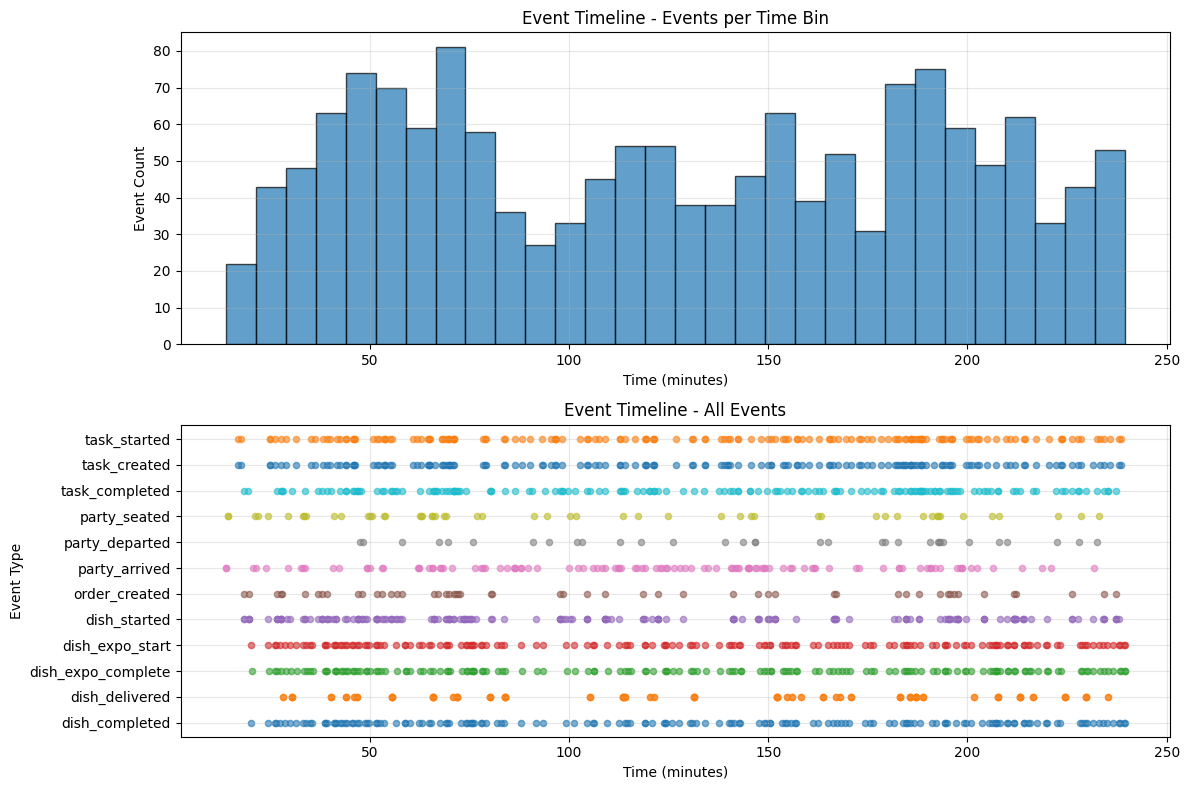


📈 Visualized 1519 events over 239.6 minutes


In [11]:
# ============================================================================
# VISUALIZE EVENT TIMELINE
# ============================================================================

import matplotlib.pyplot as plt

if sim.event_log:
    # Count events over time
    event_times = [e['timestamp'] for e in sim.event_log]
    event_types = [e['event_type'] for e in sim.event_log]
    
    # Create timeline plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot 1: Event count over time
    ax1.hist(event_times, bins=30, edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('Event Count')
    ax1.set_title('Event Timeline - Events per Time Bin')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Event types over time
    from collections import defaultdict
    event_timeline = defaultdict(list)
    for event in sim.event_log:
        event_timeline[event['event_type']].append(event['timestamp'])
    
    for event_type, times in sorted(event_timeline.items()):
        ax2.scatter(times, [event_type] * len(times), alpha=0.6, s=20)
    
    ax2.set_xlabel('Time (minutes)')
    ax2.set_ylabel('Event Type')
    ax2.set_title('Event Timeline - All Events')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 Visualized {len(sim.event_log)} events over {max(event_times):.1f} minutes")

## Getting Log File

In [12]:
from simulation import RestaurantSimulation
from parameters import SingleDishParameters
from dish_loading import load_recipes_from_json  # If using Comal recipes

# Create simulation parameters
params = SingleDishParameters()

# Configure simulation duration (in minutes)
params.simulation_duration = 240.0  # 4 hours (max for GUI)

# Enable logging
params.enable_logging = True
params.enable_event_logging = True
params.min_snapshot_interval = 0.5  # 30 seconds between snapshots

# Optional: Load Comal recipes if you want specific dishes
# load_recipes_from_json(params, "comal_recipes.json")

# Create and run simulation
sim = RestaurantSimulation(params)
results = sim.run()

# Export logs to JSON file
output_file = "logs/simulation_log.json"  # Change to your desired path
sim.export_all_logs_to_json(output_file)

print(f"Simulation complete!")
print(f"  Parties: {len(sim.parties)}")
print(f"  Snapshots: {len(sim.snapshot_history)}")
print(f"  Events: {len(sim.event_log)}")
print(f"  Revenue: ${sim.total_revenue:.2f}")
print(f"\nLogs exported to: {output_file}")

Simulation complete!
  Parties: 112
  Snapshots: 201
  Events: 748
  Revenue: $961.40

Logs exported to: logs/simulation_log.json
